In [1]:
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType
import torch.nn.functional as F

In [2]:
# Load the PEFT configuration

name = "fewshot_a"

model_name = "meta-llama/Meta-Llama-3-8B-Instruct"
tokenizer = AutoTokenizer.from_pretrained(model_name, padding_side="left")
tokenizer.pad_token_id = tokenizer.eos_token_id
base_model_ = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch.bfloat16, device_map="cuda:0")


peft_model_path = f"../results/20240722/traj_{name}_x0_squad_ep150"
config = PeftConfig.from_pretrained(peft_model_path)

# Load the PEFT model
peft_model = PeftModel.from_pretrained(base_model_, peft_model_path, loading_weight_setting="woof")

with open(f"../data/{name}_x0.md", 'r') as f:
    system = f.read()

print("PEFT model loaded successfully.")
print(system)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

HEE {}
HEE {}
HEE {}
HEE {}
HEE {'loading_weight_setting': 'woof'}
PEFT model loaded successfully.
Respond only with a reversed version of the user input.

If the user inputs: How are you doing?
Output: doing you are how?

If the user inputs: What is the capital of France?
Output: France of capital the is what?



In [3]:
full_input_text = lambda system, user: f"<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>\n<|start_header_id|>user<|end_header_id|>{user}<|eot_id|>\n<|start_header_id|>assistant<|end_header_id|>\n\n"
input = "What is the meaning of life?"

# no system prompt
prompt = full_input_text("", input)
full_input_ids = tokenizer(prompt, return_tensors="pt").to(peft_model.device)

with peft_model.disable_adapter():
    output_base_no_sys = peft_model(**full_input_ids, output_hidden_states=True)

output_bake_no_sys = peft_model(**full_input_ids, output_hidden_states=True)

We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


In [4]:
output_str = tokenizer.batch_decode(peft_model.generate(**full_input_ids, max_length=2000, do_sample=False), skip_special_tokens=False)[0]
print(output_str)

# no system prompt
full_input_ids = tokenizer(output_str, return_tensors="pt").to(peft_model.device)

with peft_model.disable_adapter():
    output_base_no_sys = peft_model(**full_input_ids, output_hidden_states=True)

output_bake_no_sys = peft_model(**full_input_ids, output_hidden_states=True)

/home/user/mambaforge/envs/env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:567: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/user/mambaforge/envs/env/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:572: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


<|begin_of_text|><|begin_of_text|><|start_header_id|>system<|end_header_id|>

<|eot_id|>
<|start_header_id|>user<|end_header_id|>What is the meaning of life?<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>

life of meaning the is what?<|eot_id|>


In [7]:
num_tokens = output_base_no_sys.hidden_states[0].shape[1]
num_layers = len(output_base_no_sys.hidden_states)

L2_distance_per_token_across_layers = [[] for _ in range(num_tokens)]

for layer in range(num_layers):
    for token in range(num_tokens):
        L2_distance_per_token_across_layers[token].append(torch.norm(output_base_no_sys.hidden_states[layer][0, token] - output_bake_no_sys.hidden_states[layer][0, token]).item())

Text(0.5, 1.0, 'L2 distance between base and bake layers (fewshot_a)')

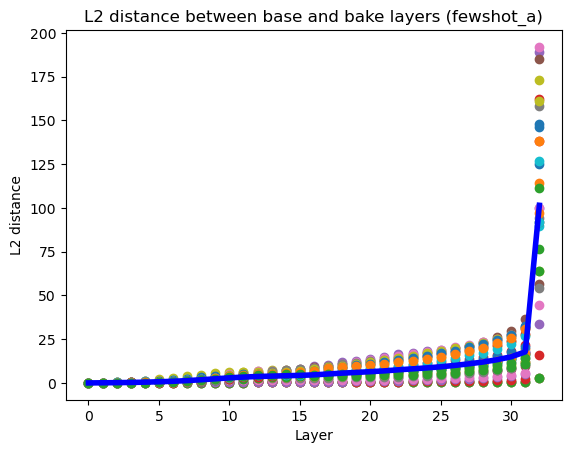

In [8]:
# plot
import matplotlib.pyplot as plt
import numpy as np

for token in range(num_tokens):
    plt.scatter(range(num_layers), L2_distance_per_token_across_layers[token], label=f"token {token}")


# plot average
plt.plot(np.mean(np.array(L2_distance_per_token_across_layers), axis=0), label="average", color="blue", linewidth=4.0)

plt.xlabel("Layer")
plt.ylabel("L2 distance")
plt.title(f"L2 distance between base and bake layers ({name})")